# Batch UCB
- use your favorite kernel to generate distance matrix
- clustering (k-metriod)
- large clustering numbers: reject clustering for which the max UCB is smaller other clustering's LCB; then choose sequences in the remaining clusterings by UCB.
- small clustering numbers, e.g. 90, choose one sequence from each clustering by UCB.

In [68]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel, WeightedDegree_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [69]:
Path = '../../data/firstRound_4h_normTrue_formatSeq_logTrue.csv'

df_frr = pd.read_csv(Path)
df_frr.head()

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.572497,NaN,2.001765,2.026102,1.866788,0.255154
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.181122,NaN,1.309597,1.693182,1.394633,0.266411
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,NaN,0.700778,NaN,0.331062,0.493596,0.508479,0.185307
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,NaN,1.287142,NaN,1.156889,1.356925,1.266986,0.101530
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,1.379619,NaN,1.406433,1.374056,1.386702,0.017312


In [70]:
df_frr.sort_values('AVERAGE', ascending=False)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
115,138,RBS_BA_48,bandit,TTTAAGACTTTTTTATACAT,CTTTTT,2.251241,1.459262,2.314395,NaN,NaN,2.008299,0.476528
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.572497,NaN,2.001765,2.026102,1.866788,0.255154
145,173,RBS_RP_54,prob random,TTTAAGATAGTCTTATACAT,TAGTCT,1.927534,1.295124,1.925422,NaN,NaN,1.716027,0.364514
114,137,RBS_BA_47,bandit,TTTAAGAGTTTTTTATACAT,GTTTTT,1.776032,1.242683,1.700069,NaN,NaN,1.572928,0.288512
59,60,RBS_1by1_60,bps_noncore,TTTAAGAAGGAGATATACAA,AGGAGA,NaN,1.290180,NaN,1.528015,1.799340,1.539178,0.254764
...,...,...,...,...,...,...,...,...,...,...,...,...
42,43,RBS_1by1_43,bps_noncore,TTTAAGAAGGAGATCTACAT,AGGAGA,NaN,-1.738476,NaN,-2.236443,-2.050203,-2.008374,0.251605
121,145,RBS_BA_55,bandit,TTTAAGAACCCCCTATACAT,ACCCCC,-1.295039,-3.277385,-1.510607,NaN,NaN,-2.027677,1.087633
29,30,RBS_1by1_30,bps_core,TTTAAGAAGTAGATATACAT,AGTAGA,NaN,-3.048645,NaN,-1.142859,-1.896742,-2.029416,0.959795
113,136,RBS_BA_46,bandit,TTTAAGATTTTTATATACAT,TTTTTA,-1.060786,-3.230272,-1.997558,NaN,NaN,-2.096205,1.088102


(array([ 8.,  4., 16., 17., 14., 28., 28., 21., 11.,  3.]),
 array([-2.22735111, -1.80378607, -1.38022104, -0.956656  , -0.53309097,
        -0.10952594,  0.3140391 ,  0.73760413,  1.16116916,  1.5847342 ,
         2.00829923]),
 <a list of 10 Patch objects>)

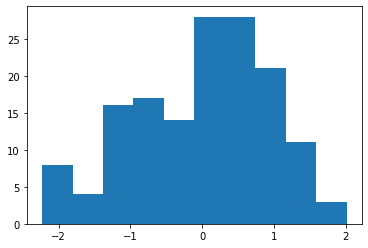

In [71]:
plt.hist(df_frr['AVERAGE'])

In [72]:
frr_rbs_set = set(df_frr['RBS'])

## Create test dataset

In [73]:
# create all combos

combos = [] # 20-base
combos_6 = [] # 6-base
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for combo in itertools.product(char_sets, repeat= design_len):
    
    combo = pre_design + ''.join(combo) + pos_design
    combos_6.append(''.join(combo))
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len
# len(combos)

In [74]:
df_design = pd.DataFrame()
df_design['RBS'] = list(set(combos) - frr_rbs_set)
#df['AVERAGE'] = NaN

In [75]:
df_design

,RBS
0,TTTAAGATTTAGCTATACAT
1,TTTAAGAGGAGACTATACAT
2,TTTAAGAGCGTTGTATACAT
3,TTTAAGACCTTATTATACAT
4,TTTAAGAGGTTCGTATACAT
...,...
3982,TTTAAGAGGTTTGTATACAT
3983,TTTAAGACCAGGTTATACAT
3984,TTTAAGAGCGACTTATACAT
3985,TTTAAGAGAGGATTATACAT


In [76]:
# put first round result (frr) and design space (design) together
# [:150] frr; [150:] design

df_train_test = pd.concat([df_frr, df_design], sort = True).reset_index()

In [77]:
df_train_test.to_csv('../../data/known_design.csv')

In [10]:
# confirm test part

df_train_test.loc[range(150,len(df_train_test))]

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0
150,0,NaN,NaN,NaN,TTTAAGATTTAGCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,1,NaN,NaN,NaN,TTTAAGAGGAGACTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,2,NaN,NaN,NaN,TTTAAGAGCGTTGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,3,NaN,NaN,NaN,TTTAAGACCTTATTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,4,NaN,NaN,NaN,TTTAAGAGGTTCGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4132,3982,NaN,NaN,NaN,TTTAAGAGGTTTGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4133,3983,NaN,NaN,NaN,TTTAAGACCAGGTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4134,3984,NaN,NaN,NaN,TTTAAGAGCGACTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4135,3985,NaN,NaN,NaN,TTTAAGAGAGGATTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## K medoids 

In [11]:
kernel_dict = {
    'Spectrum_Kernel': Spectrum_Kernel,
    'WD_Kernel': WeightedDegree_Kernel,
    'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel,
    'Mixed_Spectrum_Kernel': Mixed_Spectrum_Kernel,
    'WD_Kernel_Shift': WD_Shift_Kernel
    
}

log_flag = True

In [12]:
# setting

embedding = 'label'
eva_on_ave_flag = True # true label is the sample mean instead of individual samples, since the prediction is the posterior mean
eva_metric = mean_squared_error # mean square error returns a more stable optimal hyparameter choice than r2 score

kernel = 'WD_Kernel_Shift'
alpha = 0.5
l = [6]

weight_flag = False
padding_flag = False
gap_flag = False
plot_format = 'plt'

In [13]:
distance = kernel_dict[kernel](l_list=l).distance(np.asarray(df_train_test['RBS']))

Final normalisation


In [14]:
distance.shape

(4137, 4137)

In [15]:
kmedoids = KMedoids(n_clusters=90, metric = 'precomputed', init='k-medoids++').fit(distance)
y_km_spec = kmedoids.labels_

In [16]:
df_train_test['cluster'] = y_km_spec

In [17]:
df_train_test

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0,cluster
0,0,1.866788,reference,RBS_1by1_0,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.572497,NaN,2.001765,2.026102,0.255154,0.0,51
1,1,1.394633,bps_noncore,RBS_1by1_1,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.181122,NaN,1.309597,1.693182,0.266411,1.0,51
2,2,0.508479,bps_noncore,RBS_1by1_2,GTTAAGAAGGAGATATACAT,AGGAGA,NaN,0.700778,NaN,0.331062,0.493596,0.185307,2.0,51
3,3,1.266986,bps_noncore,RBS_1by1_3,ATTAAGAAGGAGATATACAT,AGGAGA,NaN,1.287142,NaN,1.156889,1.356925,0.101530,3.0,51
4,4,1.386702,bps_noncore,RBS_1by1_4,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,1.379619,NaN,1.406433,1.374056,0.017312,4.0,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4132,3982,NaN,NaN,NaN,TTTAAGAGGTTTGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78
4133,3983,NaN,NaN,NaN,TTTAAGACCAGGTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
4134,3984,NaN,NaN,NaN,TTTAAGAGCGACTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4135,3985,NaN,NaN,NaN,TTTAAGAGAGGATTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12


## Prediction

In [18]:
gpr = GPR_Predictor(df_train_test, train_idx = range(0,150), test_idx = range(150,len(df_train_test)), kernel_name=kernel, normalise_kernel = False, alpha=alpha, embedding='label',
                   eva_metric=eva_metric, l_list=l, s = 0)

In [19]:
gpr.regression()

X train shape:  (450, 20)
X test shape:  (3987, 20)


In [20]:
gpr.train_df

,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std
89,TTTAAGACGGATTTATACAT,CGGATT,1.010717,0.200051,bandit,Rep1,1.137678,0.995127,0.394297
90,TTTAAGACTCGGATATACAT,CTCGGA,0.438705,0.268057,bandit,Rep1,0.645691,0.473706,0.386677
91,TTTAAGAACCGGATATACAT,ACCGGA,0.323097,0.132360,bandit,Rep1,0.414381,0.226966,0.386623
92,TTTAAGAATCGGATATACAT,ATCGGA,0.240948,0.068313,bandit,Rep1,0.319189,0.250352,0.386894
93,TTTAAGACCGGATTATACAT,CCGGAT,0.060008,0.126417,bandit,Rep1,0.161740,0.050499,0.398151
...,...,...,...,...,...,...,...,...,...
684,TTTAAGAGCTACATATACAT,GCTACA,0.515899,0.229860,uni random,Rep5,0.726697,0.395371,0.397757
685,TTTAAGAGAAGACTATACAT,GAAGAC,-0.197847,0.219579,uni random,Rep5,-0.086876,-0.309530,0.385429
686,TTTAAGACTCCGTTATACAT,CTCCGT,-0.036563,0.101944,uni random,Rep5,-0.016366,-0.067617,0.396947
687,TTTAAGATTACTATATACAT,TTACTA,-0.226934,0.233238,uni random,Rep5,-0.124879,-0.307745,0.397407


In [21]:
gpr.test_df

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0,cluster,pred mean,pred std
150,0,NaN,NaN,NaN,TTTAAGATTTAGCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,-1.242692,1.656200
151,1,NaN,NaN,NaN,TTTAAGAGGAGACTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0.817297,1.108051
152,2,NaN,NaN,NaN,TTTAAGAGCGTTGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,0.025247,1.895014
153,3,NaN,NaN,NaN,TTTAAGACCTTATTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74,1.150305,1.909242
154,4,NaN,NaN,NaN,TTTAAGAGGTTCGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78,-0.235417,1.781363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4132,3982,NaN,NaN,NaN,TTTAAGAGGTTTGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78,-0.605035,1.587798
4133,3983,NaN,NaN,NaN,TTTAAGACCAGGTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1.517768,1.728250
4134,3984,NaN,NaN,NaN,TTTAAGAGCGACTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.601661,2.035316
4135,3985,NaN,NaN,NaN,TTTAAGAGAGGATTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,-0.930639,1.376279


(array([   6.,    5.,   65.,  299.,  842., 1140.,  931.,  470.,  189.,
          40.]),
 array([-3.01108207, -2.48544148, -1.95980089, -1.43416031, -0.90851972,
        -0.38287913,  0.14276145,  0.66840204,  1.19404263,  1.71968321,
         2.2453238 ]),
 <a list of 10 Patch objects>)

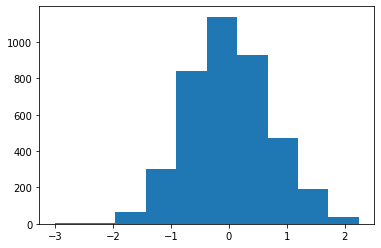

In [22]:
plt.hist(gpr.test_df['pred mean'])

In [23]:
sorted_mean_test_df = gpr.test_df.sort_values(['pred mean'], ascending=False)
sorted_mean_test_df

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0,cluster,pred mean,pred std
2210,2060,NaN,NaN,NaN,TTTAAGACCTTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87,2.245324,1.668591
369,219,NaN,NaN,NaN,TTTAAGACCGTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,2.242120,1.790419
1864,1714,NaN,NaN,NaN,TTTAAGACCGTCTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,2.196808,1.674354
1414,1264,NaN,NaN,NaN,TTTAAGACCGATTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.137446,1.563422
1287,1137,NaN,NaN,NaN,TTTAAGACCCGGCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70,2.101683,1.184091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3387,3237,NaN,NaN,NaN,TTTAAGAACCCCATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,-2.659750,0.773204
686,536,NaN,NaN,NaN,TTTAAGAATTTTGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,-2.662505,0.808115
1764,1614,NaN,NaN,NaN,TTTAAGAGCCCCGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,-2.694607,0.810892
1163,1013,NaN,NaN,NaN,TTTAAGATCCCCGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,-2.826218,0.809328


/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1.0, 'Prediction, sorted by pred mean')

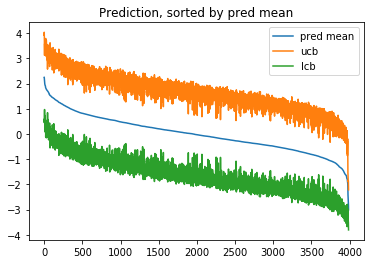

In [24]:
plt.plot(range(len(sorted_mean_test_df)), sorted_mean_test_df['pred mean'], label = 'pred mean')
plt.plot(range(len(sorted_mean_test_df)), sorted_mean_test_df['pred mean'] + sorted_mean_test_df['pred std'], label ='ucb')
plt.plot(range(len(sorted_mean_test_df)), sorted_mean_test_df['pred mean'] - sorted_mean_test_df['pred std'], label ='lcb')
plt.legend()
plt.title('Prediction, sorted by pred mean')

Final normalisation


Text(0.5, 1.0, 'Top sequences kernel matrix, sorted by pred mean')

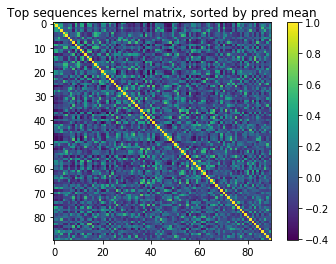

In [25]:
kernel_matrix = kernel_dict[kernel](l_list = l).__call__(np.asarray(sorted_mean_test_df['RBS'])[:90], np.asarray(sorted_mean_test_df['RBS'])[:90])
plt.imshow(kernel_matrix)
plt.colorbar()
plt.title('Top sequences kernel matrix, sorted by pred mean')

## UCB & LCB

In [26]:
test_df = gpr.test_df
test_df['ucb'] = test_df['pred mean'] + test_df['pred std']
test_df['lcb'] = test_df['pred mean'] - test_df['pred std']
test_df

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0,cluster,pred mean,pred std,ucb,lcb
150,0,NaN,NaN,NaN,TTTAAGATTTAGCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,-1.242692,1.656200,0.413508,-2.898892
151,1,NaN,NaN,NaN,TTTAAGAGGAGACTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0.817297,1.108051,1.925348,-0.290753
152,2,NaN,NaN,NaN,TTTAAGAGCGTTGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,0.025247,1.895014,1.920261,-1.869767
153,3,NaN,NaN,NaN,TTTAAGACCTTATTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74,1.150305,1.909242,3.059547,-0.758937
154,4,NaN,NaN,NaN,TTTAAGAGGTTCGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78,-0.235417,1.781363,1.545946,-2.016779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4132,3982,NaN,NaN,NaN,TTTAAGAGGTTTGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78,-0.605035,1.587798,0.982763,-2.192834
4133,3983,NaN,NaN,NaN,TTTAAGACCAGGTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1.517768,1.728250,3.246017,-0.210482
4134,3984,NaN,NaN,NaN,TTTAAGAGCGACTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.601661,2.035316,2.636977,-1.433655
4135,3985,NaN,NaN,NaN,TTTAAGAGAGGATTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,-0.930639,1.376279,0.445640,-2.306917


In [27]:
sorted_ucb = test_df.sort_values(['ucb'], ascending=False)
sorted_ucb

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0,cluster,pred mean,pred std,ucb,lcb
369,219,NaN,NaN,NaN,TTTAAGACCGTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,2.242120,1.790419,4.032539,0.451701
2210,2060,NaN,NaN,NaN,TTTAAGACCTTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87,2.245324,1.668591,3.913915,0.576732
1864,1714,NaN,NaN,NaN,TTTAAGACCGTCTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,2.196808,1.674354,3.871163,0.522454
2774,2624,NaN,NaN,NaN,TTTAAGACCTGTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,1.831006,1.954273,3.785279,-0.123267
2045,1895,NaN,NaN,NaN,TTTAAGACAGTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,1.923864,1.845378,3.769242,0.078486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,536,NaN,NaN,NaN,TTTAAGAATTTTGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,-2.662505,0.808115,-1.854390,-3.470621
1764,1614,NaN,NaN,NaN,TTTAAGAGCCCCGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,-2.694607,0.810892,-1.883715,-3.505499
3387,3237,NaN,NaN,NaN,TTTAAGAACCCCATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,-2.659750,0.773204,-1.886546,-3.432954
1163,1013,NaN,NaN,NaN,TTTAAGATCCCCGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,-2.826218,0.809328,-2.016889,-3.635546


/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1.0, 'Prediction, sorted by ucb')

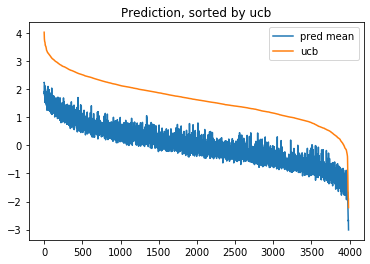

In [28]:

plt.plot(range(len(sorted_ucb)), sorted_ucb['pred mean'], label = 'pred mean')
plt.plot(range(len(sorted_ucb)), sorted_ucb['ucb'], label = 'ucb')
plt.legend()
plt.title('Prediction, sorted by ucb')

(array([26., 23., 11.,  5., 12.,  4.,  4.,  2.,  2.,  1.]),
 array([3.15079113, 3.2389659 , 3.32714068, 3.41531546, 3.50349023,
        3.59166501, 3.67983978, 3.76801456, 3.85618934, 3.94436411,
        4.03253889]),
 <a list of 10 Patch objects>)

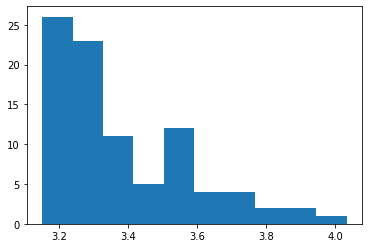

In [29]:
plt.hist(sorted_ucb[:90]['ucb'])

Final normalisation


Text(0.5, 1.0, 'Top sequences kernel matrix, sorted by ucb')

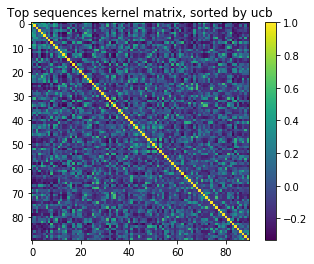

In [30]:
sorted_ucb_kernel_matrix = kernel_dict[kernel](l_list = l).__call__(np.asarray(sorted_ucb['RBS'])[:90], np.asarray(sorted_ucb['RBS'])[:90])
plt.imshow(sorted_ucb_kernel_matrix)
plt.colorbar()
plt.title('Top sequences kernel matrix, sorted by ucb')

In [31]:
sorted_ucb.groupby('cluster').max()['ucb'].min()

1.8224653363637502

In [32]:
sorted_ucb.groupby('cluster').min()['lcb'].max()

-1.4008135968221354

## Clustering idea

### Discussion: Reject clusters with max ucb smaller min lcb in another cluster?
For 256 clusters, the minimum max ucb among all clusters is 1.35, which is still bigger than maximum min lcb among all clusters (- 1.05)
When we look at single sequences, there are sequence's ucb is smaller than other's lcb.

### Discussion: Select max ucb in each clusters

In [33]:
max_ucb_in_clusters = pd.DataFrame(columns=['RBS', 'ucb', 'pred mean', 'pred std', 'lcb'])

for group, value in sorted_ucb.groupby('cluster'):
    max_ucb_in_clusters.loc[group] = value.sort_values('ucb', ascending = False)[['RBS', 'ucb', 'pred mean', 'pred std', 'lcb']].iloc[0]
    

In [34]:
max_ucb_in_clusters

,RBS,ucb,pred mean,pred std,lcb
0,TTTAAGACATGAGTATACAT,3.191061,1.480831,1.710230,-0.229399
1,TTTAAGACCGATTTATACAT,3.700868,2.137446,1.563422,0.574024
2,TTTAAGAACGTAATATACAT,2.437429,0.741937,1.695492,-0.953555
3,TTTAAGATTCTTTTATACAT,2.470035,0.614874,1.855160,-1.240286
4,TTTAAGAATATACTATACAT,2.297004,0.803959,1.493045,-0.689085
...,...,...,...,...,...
85,TTTAAGACCTAACTATACAT,2.851868,0.871245,1.980623,-1.109378
86,TTTAAGATATGGCTATACAT,2.810310,1.062783,1.747527,-0.684745
87,TTTAAGACCTTTTTATACAT,3.913915,2.245324,1.668591,0.576732
88,TTTAAGATGCGGCTATACAT,2.537872,0.802602,1.735270,-0.932667


Text(0.5, 1.0, 'max_ucb_in_clusters')

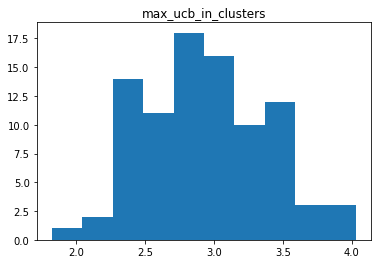

In [35]:
plt.hist(max_ucb_in_clusters['ucb'])
plt.title('max_ucb_in_clusters')

In [36]:
sorted_max_ucb_in_clusters = max_ucb_in_clusters.sort_values('ucb', ascending=False)
sorted_max_ucb_in_clusters

,RBS,ucb,pred mean,pred std,lcb
47,TTTAAGACCGTTTTATACAT,4.032539,2.242120,1.790419,0.451701
87,TTTAAGACCTTTTTATACAT,3.913915,2.245324,1.668591,0.576732
69,TTTAAGACCGTCTTATACAT,3.871163,2.196808,1.674354,0.522454
1,TTTAAGACCGATTTATACAT,3.700868,2.137446,1.563422,0.574024
70,TTTAAGACCTGGCTATACAT,3.667069,1.811347,1.855722,-0.044375
...,...,...,...,...,...
45,TTTAAGACAGCCCTATACAT,2.291941,0.411979,1.879962,-1.467983
18,TTTAAGAAGCTAGTATACAT,2.275652,0.491803,1.783849,-1.292046
52,TTTAAGAAATGGCTATACAT,2.186695,0.536071,1.650623,-1.114552
13,TTTAAGATTCGAGTATACAT,2.133227,0.344890,1.788337,-1.443448


Final normalisation


Text(0.5, 1.0, 'sorted_max_ucb_clusters_kernel_matrix')

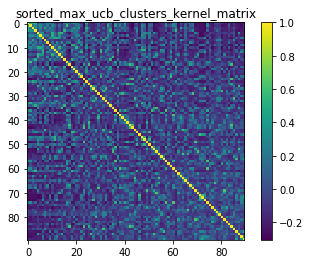

In [37]:
sorted_max_ucb_clusters_kernel_matrix = kernel_dict[kernel](l_list = l).__call__(np.asarray(sorted_max_ucb_in_clusters['RBS']), np.asarray(sorted_max_ucb_in_clusters['RBS']))
plt.imshow(sorted_max_ucb_clusters_kernel_matrix)
plt.colorbar()
plt.title('sorted_max_ucb_clusters_kernel_matrix')

we can see compared with selecting top 100 sequences directly, selecting max ucb in each cluster results in a distrubiton with lower ucbs, but lower similarities as well.

## GP-BUCB

In [39]:
from copy import deepcopy
gpr_copy = deepcopy(gpr)

In [40]:
# Fix beta = 1 for now
# Desautels et al. 2014 Algorithm 2
# http://jmlr.org/papers/volume15/desautels14a/desautels14a.pdf

batch_size = 90
rec_df = pd.DataFrame()

gpr = deepcopy(gpr_copy)

gpr.train_idx = range(0,150)
gpr.test_idx = range(150,len(df_train_test))

sorted_ucb_batch = sorted_ucb

for i in range(batch_size):
    print(i)
    rec = pd.DataFrame(sorted_ucb_batch.head(1))
    rec_df = rec_df.append(rec, ignore_index = True)
    
    rec_idx = sorted_ucb_batch.index[0]
    
    train_idx = list(gpr.train_idx)
    train_idx.append(rec_idx)
    gpr.train_idx = train_idx
    
    # add replicates label to avoid being droped
    gpr.df.loc[rec_idx,'Rep2'] = gpr.test_df.loc[rec_idx,'pred mean']
    gpr.df.loc[rec_idx,'AVERAGE'] = gpr.test_df.loc[rec_idx,'pred mean']
    
    test_idx = list(gpr.test_idx)
    test_idx.remove(rec_idx)
    gpr.test_idx = test_idx
    
    gpr.regression()
    
    test_batch_df = gpr.test_df
    test_batch_df['ucb'] = test_df['pred mean'] + test_batch_df['pred std']
    test_batch_df['lcb'] = test_df['pred mean'] - test_batch_df['pred std']
    sorted_ucb_batch = test_batch_df.sort_values(['ucb'], ascending=False)

0
X train shape:  (451, 20)
X test shape:  (3986, 20)
1
X train shape:  (452, 20)
X test shape:  (3985, 20)
2
X train shape:  (453, 20)
X test shape:  (3984, 20)
3
X train shape:  (454, 20)
X test shape:  (3983, 20)
4
X train shape:  (455, 20)
X test shape:  (3982, 20)
5
X train shape:  (456, 20)
X test shape:  (3981, 20)
6
X train shape:  (457, 20)
X test shape:  (3980, 20)
7
X train shape:  (458, 20)
X test shape:  (3979, 20)
8
X train shape:  (459, 20)
X test shape:  (3978, 20)
9
X train shape:  (460, 20)
X test shape:  (3977, 20)
10
X train shape:  (461, 20)
X test shape:  (3976, 20)
11
X train shape:  (462, 20)
X test shape:  (3975, 20)
12
X train shape:  (463, 20)
X test shape:  (3974, 20)
13
X train shape:  (464, 20)
X test shape:  (3973, 20)
14
X train shape:  (465, 20)
X test shape:  (3972, 20)
15
X train shape:  (466, 20)
X test shape:  (3971, 20)
16
X train shape:  (467, 20)
X test shape:  (3970, 20)
17
X train shape:  (468, 20)
X test shape:  (3969, 20)
18
X train shape:  (

In [43]:
sorted_ucb.head(90)

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0,cluster,pred mean,pred std,ucb,lcb
369,219,NaN,NaN,NaN,TTTAAGACCGTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,2.242120,1.790419,4.032539,0.451701
2210,2060,NaN,NaN,NaN,TTTAAGACCTTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87,2.245324,1.668591,3.913915,0.576732
1864,1714,NaN,NaN,NaN,TTTAAGACCGTCTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,2.196808,1.674354,3.871163,0.522454
2774,2624,NaN,NaN,NaN,TTTAAGACCTGTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,1.831006,1.954273,3.785279,-0.123267
2045,1895,NaN,NaN,NaN,TTTAAGACAGTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,1.923864,1.845378,3.769242,0.078486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,1979,NaN,NaN,NaN,TTTAAGAGCTGGCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1.386276,1.777235,3.163511,-0.390959
682,532,NaN,NaN,NaN,TTTAAGACCTTGGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1.174424,1.986972,3.161397,-0.812548
3817,3667,NaN,NaN,NaN,TTTAAGACCAGTGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46,1.515363,1.638069,3.153432,-0.122706
3554,3404,NaN,NaN,NaN,TTTAAGACCTTCCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70,1.240190,1.912068,3.152258,-0.671878


In [41]:
rec_df

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0,cluster,pred mean,pred std,ucb,lcb
0,219,NaN,NaN,NaN,TTTAAGACCGTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,2.242120,1.790419,4.032539,0.451701
1,2060,NaN,NaN,NaN,TTTAAGACCTTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87,2.349419,1.630017,3.875341,0.615307
2,1714,NaN,NaN,NaN,TTTAAGACCGTCTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,2.428735,1.504627,3.701435,0.692181
3,2624,NaN,NaN,NaN,TTTAAGACCTGTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,2.136615,1.818524,3.649530,0.012483
4,1881,NaN,NaN,NaN,TTTAAGACCATTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,2.185321,1.677143,3.617372,0.263087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,3981,NaN,NaN,NaN,TTTAAGACCGTAATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54,1.745001,1.162337,2.663573,0.338899
86,3203,NaN,NaN,NaN,TTTAAGACGTGAGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,1.732560,1.206270,2.662192,0.249652
87,543,NaN,NaN,NaN,TTTAAGAGTTGGGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,1.878732,0.970390,2.662048,0.721267
88,3835,NaN,NaN,NaN,TTTAAGACCTGCTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,2.527339,1.130669,2.660466,0.399127


Final normalisation


Text(0.5, 1.0, 'GP-BUCB sequences kernel matrix, sorted by ucb')

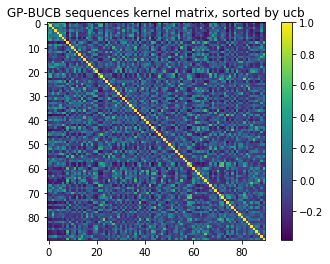

In [45]:
sorted_gpbucb_kernel_matrix = kernel_dict[kernel](l_list = l).__call__(np.asarray(rec_df['RBS']), np.asarray(rec_df['RBS']))
plt.imshow(sorted_gpbucb_kernel_matrix)
plt.colorbar()
plt.title('GP-BUCB sequences kernel matrix, sorted by ucb')

## plot together

Text(0.5, 1.0, 'sorted ucb')

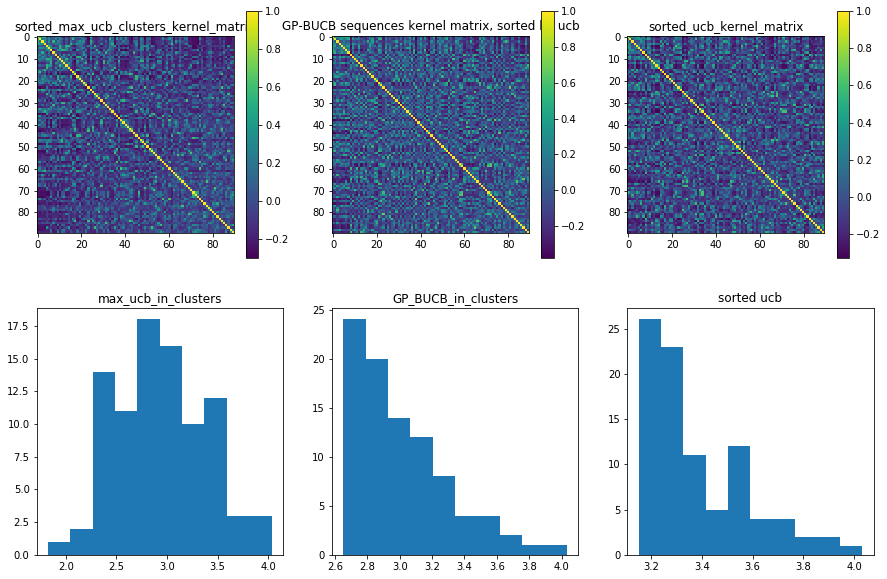

In [47]:
num_rows = 2
num_cols = 3


fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

im = a[0][0].imshow(sorted_max_ucb_clusters_kernel_matrix, cmap = 'viridis')
fig.colorbar(im, ax =a[0][0])
a[0][0].set_title('sorted_max_ucb_clusters_kernel_matrix')


im = a[0][1].imshow(sorted_gpbucb_kernel_matrix, cmap = 'viridis')
fig.colorbar(im, ax =a[0][1])
a[0][1].set_title('GP-BUCB sequences kernel matrix, sorted by ucb')

im = a[0][2].imshow(sorted_ucb_kernel_matrix, cmap = 'viridis')
fig.colorbar(im, ax =a[0][2])
a[0][2].set_title('sorted_ucb_kernel_matrix')

im = a[1][0].hist(max_ucb_in_clusters['ucb'])
a[1][0].set_title('max_ucb_in_clusters')

im = a[1][1].hist(rec_df['ucb'])
a[1][1].set_title('GP_BUCB_in_clusters')

im = a[1][2].hist(sorted_ucb[:90]['ucb'])
a[1][2].set_title('sorted ucb')

In [62]:
# save file  

with pd.ExcelWriter('batch_ucb.xlsx') as writer:
    rec_df.to_excel(writer, sheet_name = 'gpbucb')
    max_ucb_in_clusters.to_excel(writer, sheet_name = 'clusterucb')
    sorted_ucb.to_excel(writer, sheet_name = 'sorteducb')

In [65]:
# pd.read_excel('batch_ucb.xlsx', sheet_name='sorteducb')